# Check out the Clay v1 model on the dataset

## Acknowledgements
Notebook adapted from https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html and https://github.com/Clay-foundation/model/blob/main/docs/tutorials/clay-v1-wall-to-wall.ipynb

In [31]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import pyproj
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from torchvision.transforms import v2
from einops import rearrange

import shapely
import json

from src.models.clay.model import ClayMAEModule

from src.data.get_satellite_images import ReadSTAC

In [32]:
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
# bands from B01 to B12
# bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
bands = ['B02', 'B03', 'B04', 'B08']

stac_reader = ReadSTAC(api_url=api_url)

# Load Dataset

In [33]:
gpd.list_layers("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg")

name geometry_type
0          tiles       Polygon
1  maus_polygons       Polygon
2  tang_polygons       Polygon
3    maus_bboxes       Polygon
4    tang_bboxes       Polygon

In [34]:
# load the processed dataset
tiles = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="tiles")
maus_polygons = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="maus_polygons")
tang_polygons = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="tang_polygons")

maus_bboxes = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="maus_bboxes")
tang_bboxes = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="tang_bboxes")

In [35]:
# select first row
row = tiles.iloc[1]
row

tile_id                                                           1866
s2_tile_id           S2B_MSIL2A_20190121T041059_R047_T46RGN_2020100...
source_dataset                                                    maus
preferred_dataset                                                 maus
minetype1                                                      Surface
minetype2                                                   Industrial
comment                                                               
timestamp                                   2024-06-28 09:11:40.081000
geometry             POLYGON ((95.68251836756677 24.655845657947932...
Name: 1, dtype: object

In [36]:
# convert geojson string to shapely geometry
bounds = row.geometry.bounds
bounds

(95.48032837984542, 24.655845657947932, 95.68648968114054, 24.84410976758714)

In [37]:
# get lat and lon
lat = row.geometry.centroid.y
lon = row.geometry.centroid.x
lat, lon

(24.749993136227427, 95.58333264336541)

# Load Items and stack for the first row

In [38]:
# get the item 
item = stac_reader.get_item_by_name(row.s2_tile_id, bbox=bounds)

# read as stack
stack = stac_reader.get_stack(
    items=item, 
    bands=bands,
    crop_to_bounds=False, 
    squeeze_time_dim=False,
    custom_point_and_buffer=[lon, lat, 10240],
    chunk_size=512,
    )
stack

Loading stack...
Returning stack from single S2 image with ID: S2B_MSIL2A_20190121T041059_R047_T46RGN_20201008T032645


<xarray.DataArray 'stackstac-6eb4bf91da8b536facc69bbde1f141db' (time: 1,
                                                                band: 4,
                                                                y: 2048, x: 2048)> Size: 67MB
dask.array<getitem, shape=(1, 4, 2048, 2048), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 8B 2019-01...
    id                                       (time) <U54 216B 'S2B_MSIL2A_201...
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 16kB 7.51e+05 ... 7....
  * y                                        (y) float64 16kB 2.75e+06 ... 2....
    proj:epsg                                int64 8B 32646
    ...                                       ...
    proj:transform                           object 8B {0.0, 10.0, 2800020.0,...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32646
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20190121T0...
Attributes:
    spec:        RasterSpec(epsg=32646, bounds=(699960, 2690220, 809760, 2800...
    crs:         epsg:32646
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 2800020.00|\n| 0.0...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20190121T041059_R047_T46RGN_20201008T032645

### Load the model

We now have the data to analyse, let's load the model.

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

Downloading: "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt" to /home/zeus/.cache/torch/hub/checkpoints/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt
100%|██████████| 1.61G/1.61G [01:16<00:00, 22.7MB/s]


### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use medata file of the model to extract those values. But this cloud also be something custom for a different platform.

In [40]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert the band pixel data in to the format for the model

We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [41]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = [stack["s2:generation_time"].values.astype("datetime64[s]").tolist()]
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32).compute())
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all of these inputs into a dictionary that combines everything.

In [42]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [43]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()
embeddings.shape

RuntimeError: [enforce fail at alloc_cpu.cpp:83] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 206164721712 bytes. Error code 12 (Cannot allocate memory)

### Visualize the original image

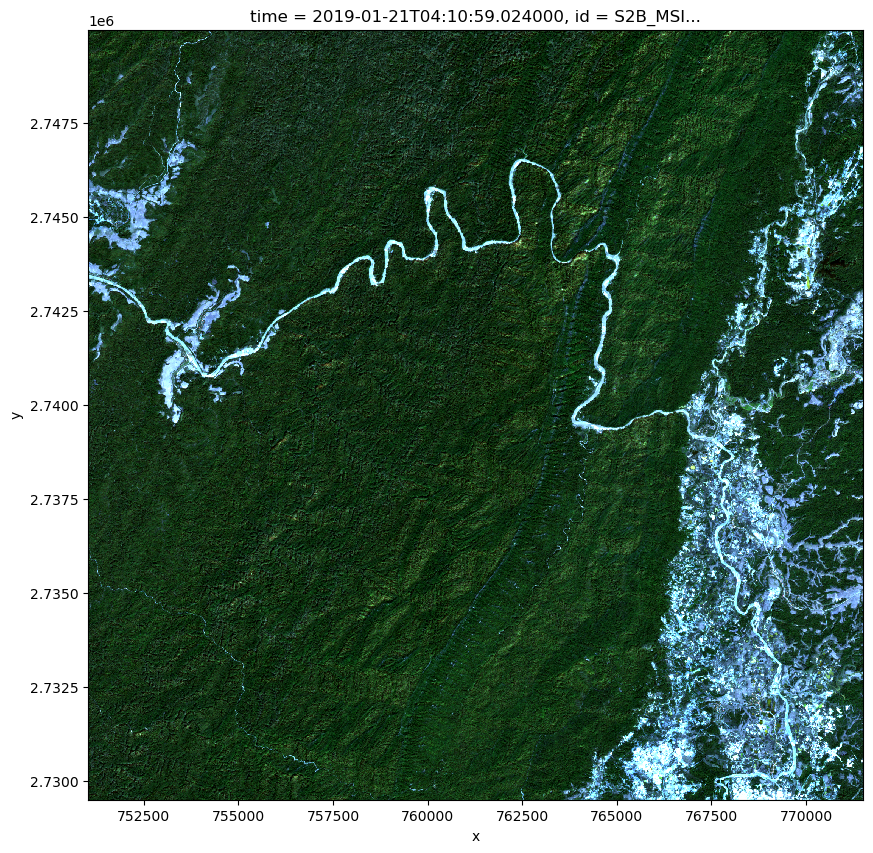

In [ ]:
# visualize the image
image_stack = stack[0, :3, :, :]
image_stack.plot.imshow(robust=True, figsize=(10, 10))

### Explore the embeddings
ClayMAE model is trained using patch_size of 8. For chip_size of 664 x 664, we have

664 // 8 -> 83 rows
664 // 8 -> 83 cols

83 * 83 -> 6889 patches are passed through the forward pass of the model.

Here we see unmsk_patch shapes of size batch x (1 + 6889) x 768, i.e
1 -> cls_token
6889 -> patches
768 -> embedding dim

In [ ]:
print(unmsk_patch.shape)
embeddings.shape

torch.Size([1, 6890, 768])


(1, 768)

Rearrange the embeddings from the Clay Encoder back to images.

Embeddings are of shape: ``batch x (1:cls_token + 784:patches) x 768:embedding dimension``

``784:patches`` can be transformed into images of shape ``28 x 28``

``768:embedding`` dimension can be moved as channel dimension

Here, each embedding dims represents a particular unique feature of the chip

In [ ]:
unmsk_embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=83, w=83
)

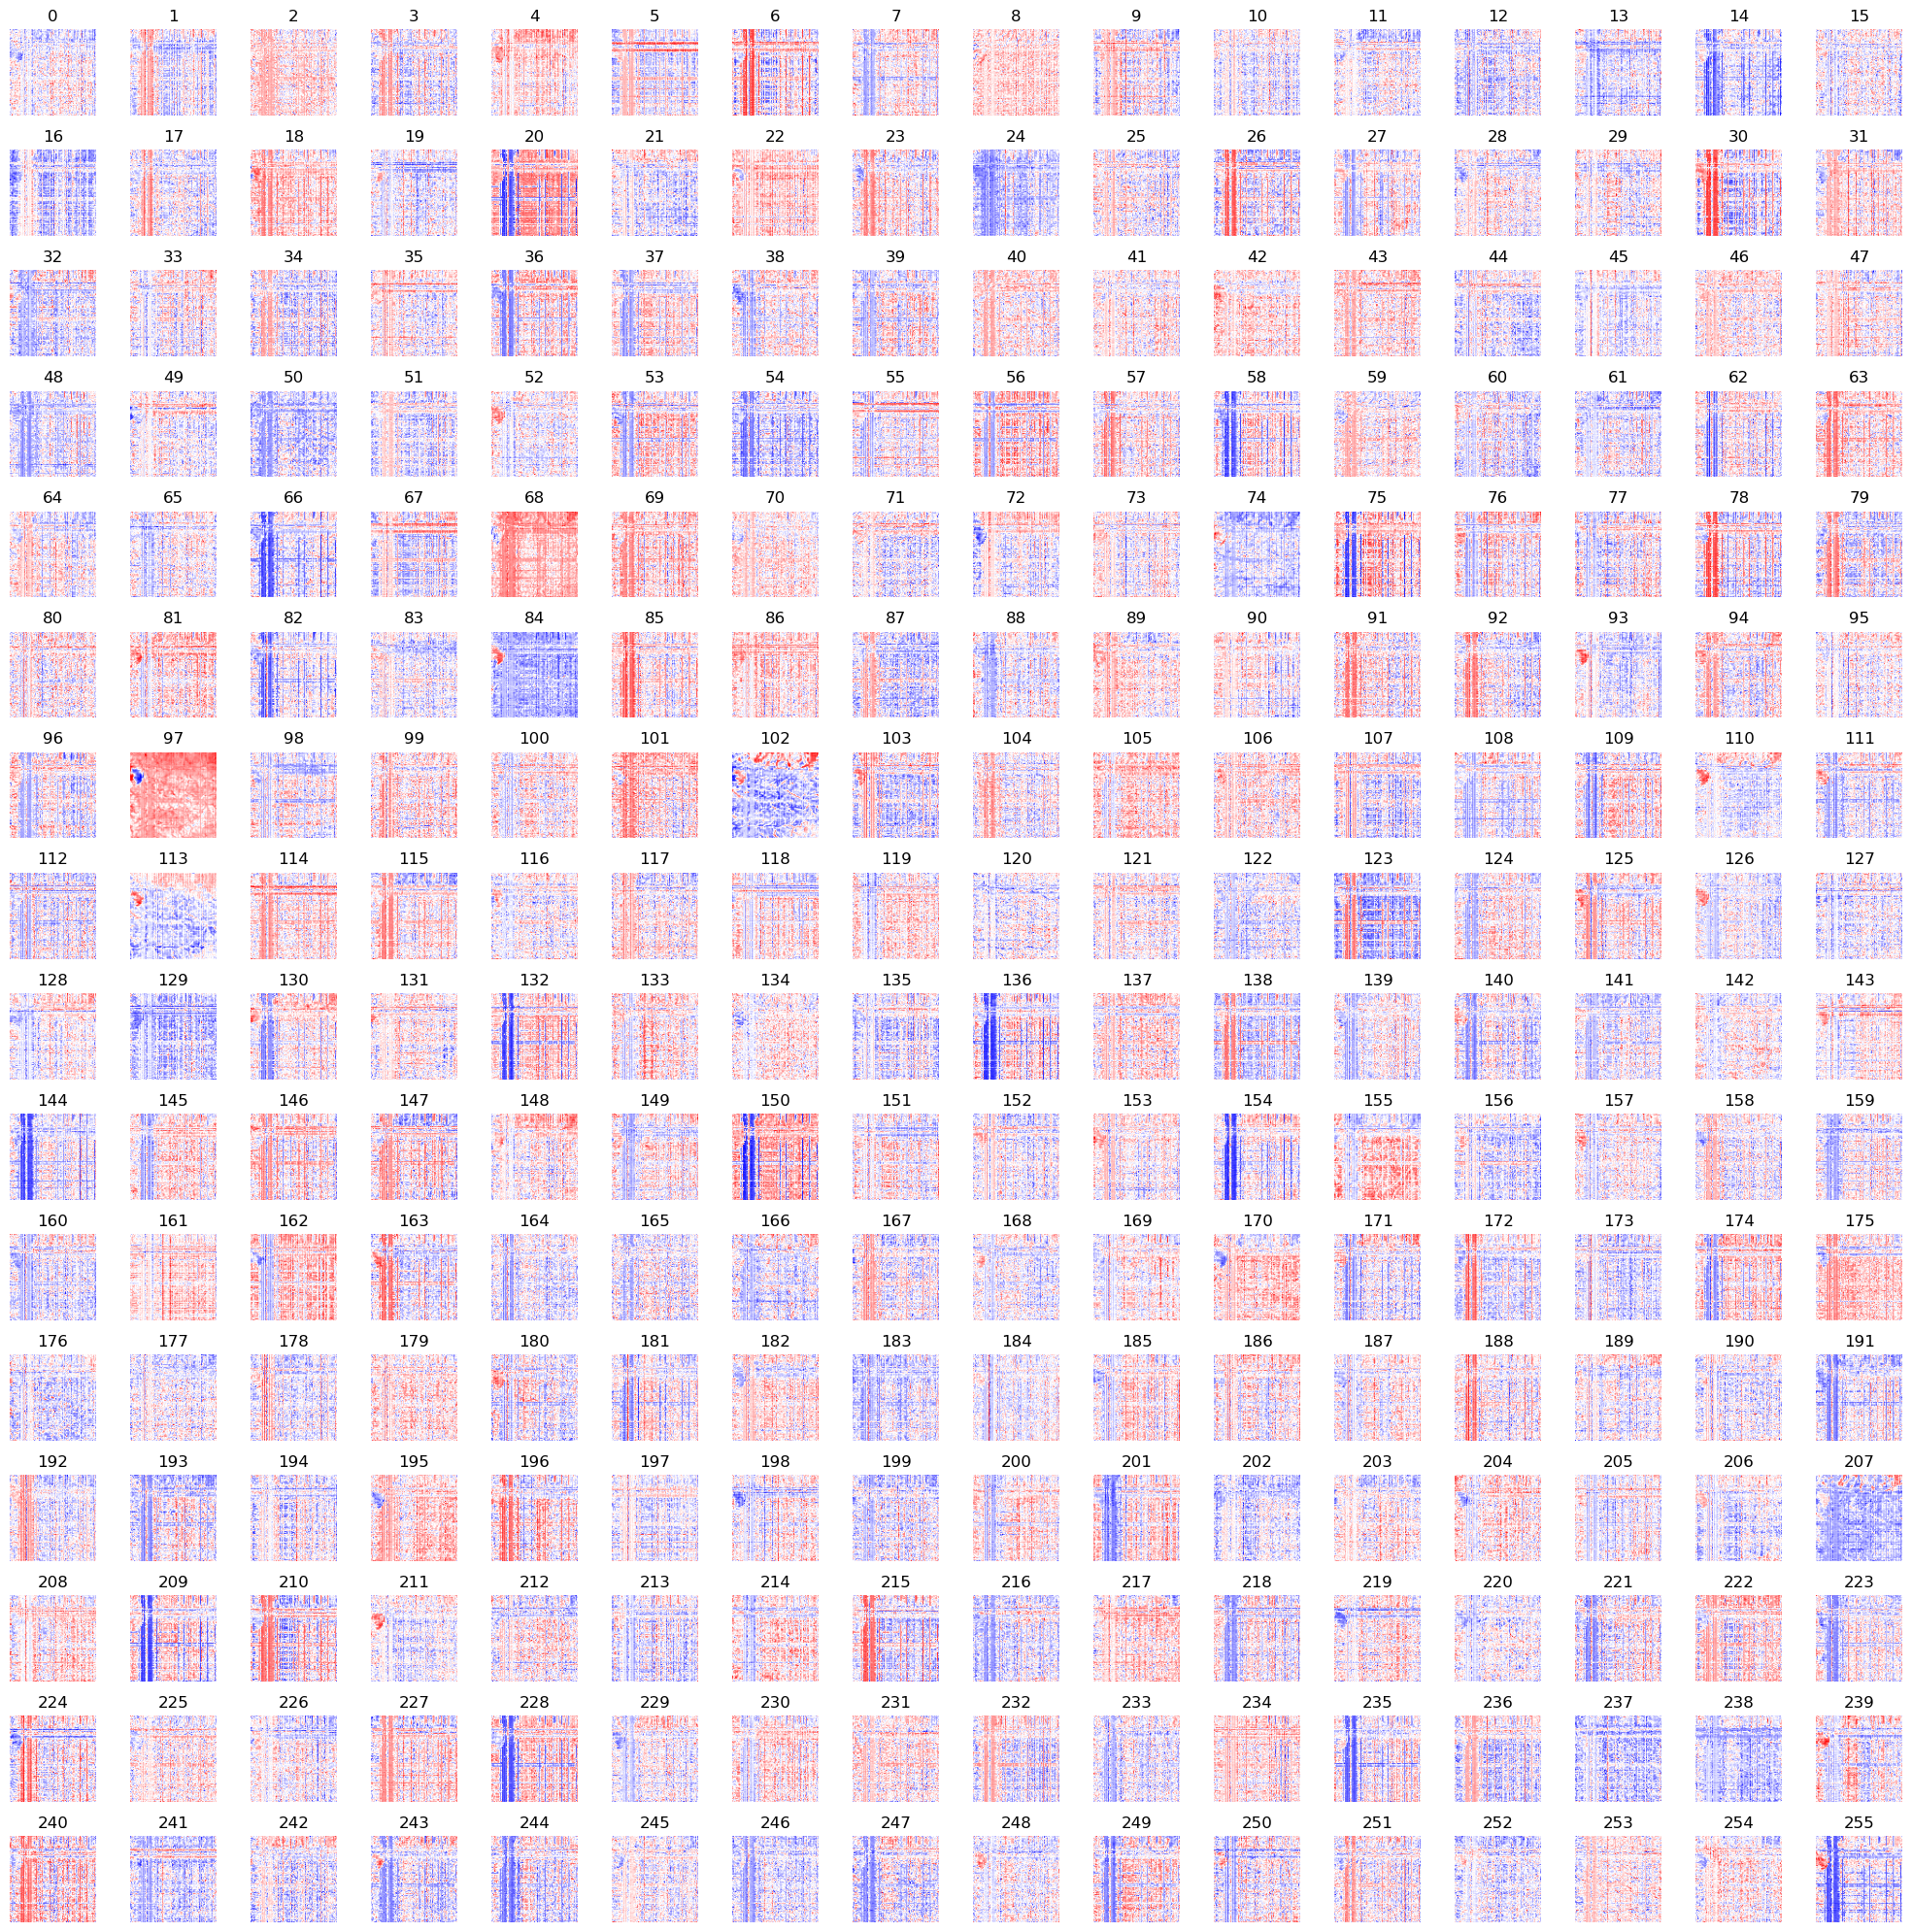

In [ ]:
# choose only the first image (there is only one anyway)
embed = unmsk_embed[0] 

fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)
plt.tight_layout()

# Test a small decoder to locate the mine bbox

In [ ]:
# TODO